<a href="https://colab.research.google.com/github/MohamedMadhoun/House-Price-Prediction-NN/blob/main/Kaggle_House_Price_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 1. Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

# Sci-kit learn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [5]:

import pandas as pd



# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display first few rows
train_df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_df.isna().sum()

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


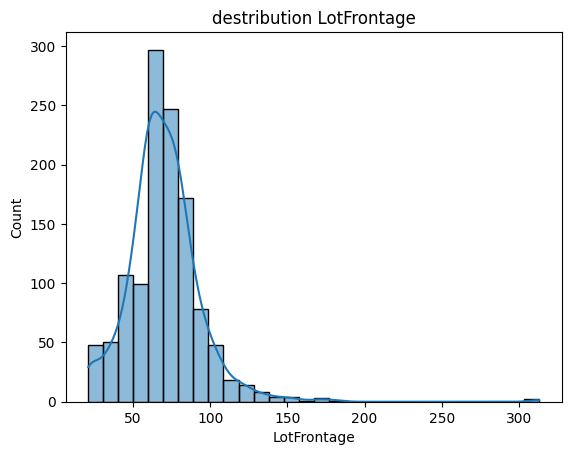

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train_df['LotFrontage'].dropna(), bins=30, kde=True)
plt.title("destribution LotFrontage")
plt.show()

In [8]:
train_df[train_df['LotFrontage'].isnull()]['Neighborhood'].value_counts()


,count
Neighborhood,
NAmes,39
Gilbert,30
NWAmes,28
Sawyer,26
CollgCr,24
ClearCr,15
Mitchel,13
Crawfor,10
SawyerW,9


In [9]:
train_df[train_df['LotFrontage'].isnull()]['MSSubClass'].value_counts()


,count
MSSubClass,
20,99
60,69
80,20
120,20
50,16
160,8
85,6
30,6
90,5


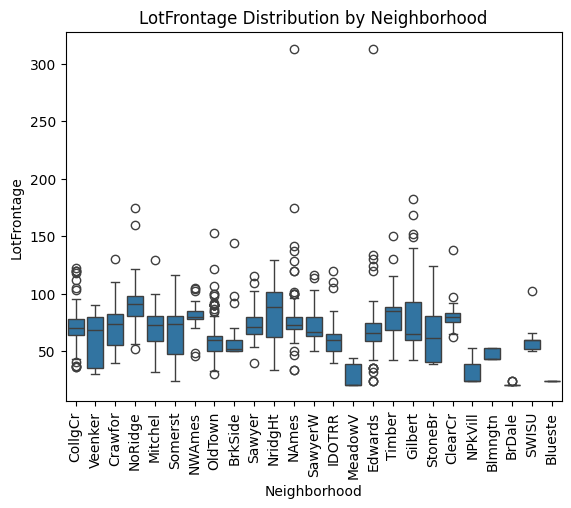

In [10]:
sns.boxplot(x='Neighborhood', y='LotFrontage', data=train_df)
plt.xticks(rotation=90)
plt.title("LotFrontage Distribution by Neighborhood")
plt.show()


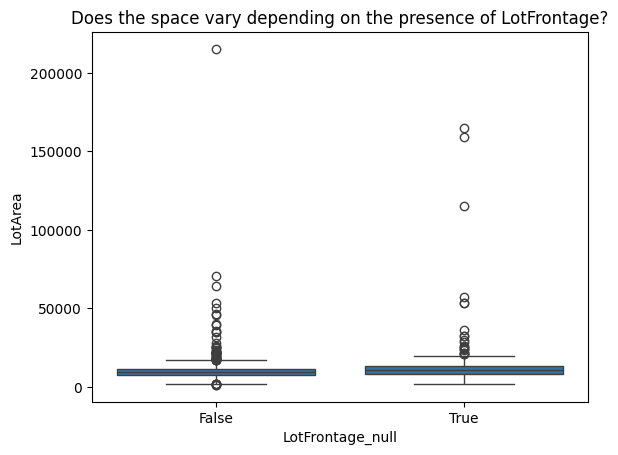

In [11]:
train_df['LotFrontage_null'] = train_df['LotFrontage'].isnull()

sns.boxplot(x='LotFrontage_null', y='LotArea', data=train_df)
plt.title("Does the space vary depending on the presence of LotFrontage?")
plt.show()


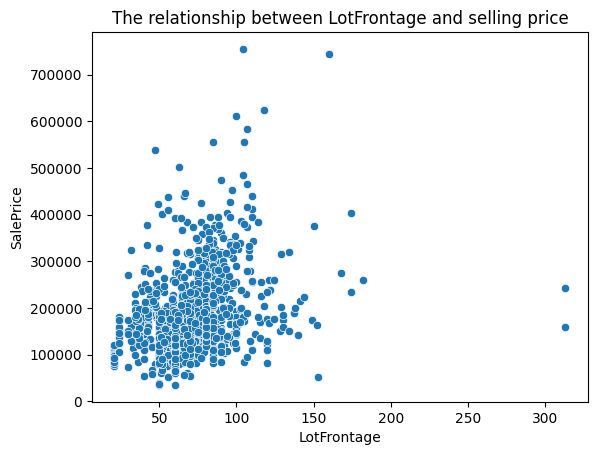

In [12]:
sns.scatterplot(x='LotFrontage', y='SalePrice', data=train_df)
plt.title("The relationship between LotFrontage and selling price")
plt.show()


In [13]:
train_df['LotFrontage_missing'] = train_df['LotFrontage'].isnull().astype(int)


In [14]:
import pandas as pd

for col in ['LotConfig', 'LotShape', 'MSZoning']:
    ct = pd.crosstab(train_df['LotFrontage_missing'], train_df[col])
    print(f"Distribution in {col}:")

    print(ct)
    print("\n")


Distribution in LotConfig:
LotConfig            Corner  CulDSac  FR2  FR3  Inside
LotFrontage_missing                                   
0                       201       45   33    4     918
1                        62       49   14    0     134


Distribution in LotShape:
LotShape             IR1  IR2  IR3  Reg
LotFrontage_missing                    
0                    317   26    7  851
1                    167   15    3   74


Distribution in MSZoning:
MSZoning             C (all)  FV  RH   RL   RM
LotFrontage_missing                           
0                         10  57  13  922  199
1                          0   8   3  229   19




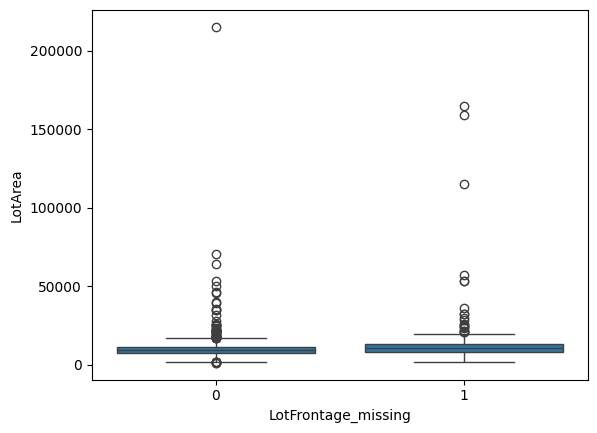

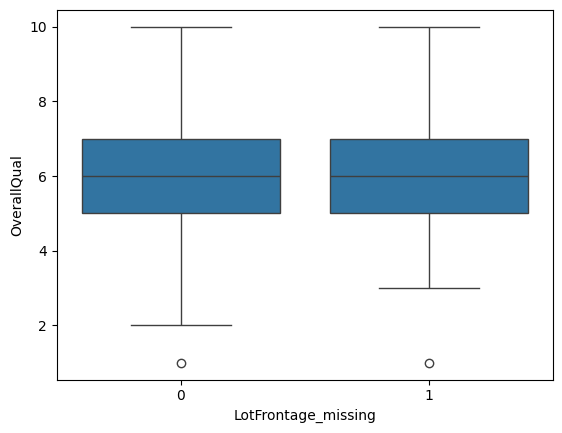

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['LotArea', 'OverallQual']:
    sns.boxplot(x='LotFrontage_missing', y=col, data=train_df)
    plt.show()


In [16]:
from scipy.stats import ttest_ind

group_missing = train_df[train_df['LotFrontage_missing'] == 1]['LotArea'].dropna()
group_not_missing = train_df[train_df['LotFrontage_missing'] == 0]['LotArea'].dropna()

t_stat, p_value = ttest_ind(group_missing, group_not_missing)
print(f"t-test for LotArea: t={t_stat:.3f}, p={p_value:.3f}")


t-test for LotArea: t=4.692, p=0.000


In [17]:
from scipy.stats import chi2_contingency

ct = pd.crosstab(train_df['LotFrontage_missing'], train_df['LotConfig'])
chi2, p, dof, ex = chi2_contingency(ct)
print(f"Chi-square test for LotConfig: chi2={chi2:.3f}, p={p:.3f}")


Chi-square test for LotConfig: chi2=105.883, p=0.000


In [18]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler

# y = train_df['SalePrice']
# X = train_df.drop(columns=['Id', 'SalePrice'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# imputer = SimpleImputer(strategy='median')

# X_train[num_cols] = imputer.fit_transform(X_train[num_cols])
# X_test[num_cols] = imputer.transform(X_test[num_cols])

# X_combined = pd.concat([X_train, X_test], axis=0)
# X_combined = pd.get_dummies(X_combined)

# X_train = X_combined.iloc[:len(X_train), :]
# X_test = X_combined.iloc[len(X_train):, :]

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

y = train_df['SalePrice']
X = train_df.drop(columns=['Id', 'SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

group_medians = (
    X_train.groupby(['Neighborhood', 'LotConfig', 'LotShape', 'MSZoning'])['LotFrontage']
    .median()
    .reset_index()
    .rename(columns={'LotFrontage': 'LF_median'})
)

X_train = X_train.merge(group_medians, on=['Neighborhood', 'LotConfig', 'LotShape', 'MSZoning'], how='left')
X_test = X_test.merge(group_medians, on=['Neighborhood', 'LotConfig', 'LotShape', 'MSZoning'], how='left')

fallback = X_train['LotFrontage'].median()
X_train['LotFrontage'] = X_train['LotFrontage'].fillna(X_train['LF_median']).fillna(fallback)
X_test['LotFrontage'] = X_test['LotFrontage'].fillna(X_test['LF_median']).fillna(fallback)

X_train = X_train.drop(columns='LF_median')
X_test = X_test.drop(columns='LF_median')

num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

imputer = SimpleImputer(strategy='median')
X_train[num_cols] = imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer.transform(X_test[num_cols])

X_combined = pd.concat([X_train, X_test], axis=0)
X_combined = pd.get_dummies(X_combined)

X_train = X_combined.iloc[:len(X_train), :]
X_test = X_combined.iloc[len(X_train):, :]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

price_scaler = StandardScaler()
y_train_scaled = price_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = price_scaler.transform(y_test.values.reshape(-1, 1))


In [20]:
# 4. Define Plot Function

# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
    metrics = [c for c in history.history if not c.startswith('val_')]
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    if len(metrics) == 1:
        axes = [axes]
    for i, metric_name in enumerate(metrics):
        ax = axes[i]
        metric_values = history.history[metric_name]
        epochs = history.epoch
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes


In [21]:
input_shape = X_train_scaled.shape[1]
input_shape


289

In [22]:
# 5. Model 1 - Basic Neural Network

# Build regression model within function
def build_model():
    # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(256, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(128,
                activation = 'relu'))

    model.add(Dense(1, activation = 'linear'))

    # Compile Model
    model.compile(loss = 'mae', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model


In [23]:
reg_model = build_model()

# Get model summary
reg_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,265 (419.00 KB)

 Trainable params: 107,265 (419.00 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = reg_model.fit(X_train_scaled, y_train,
                        validation_split = .2,
                        epochs=150,
                        verbose=0)


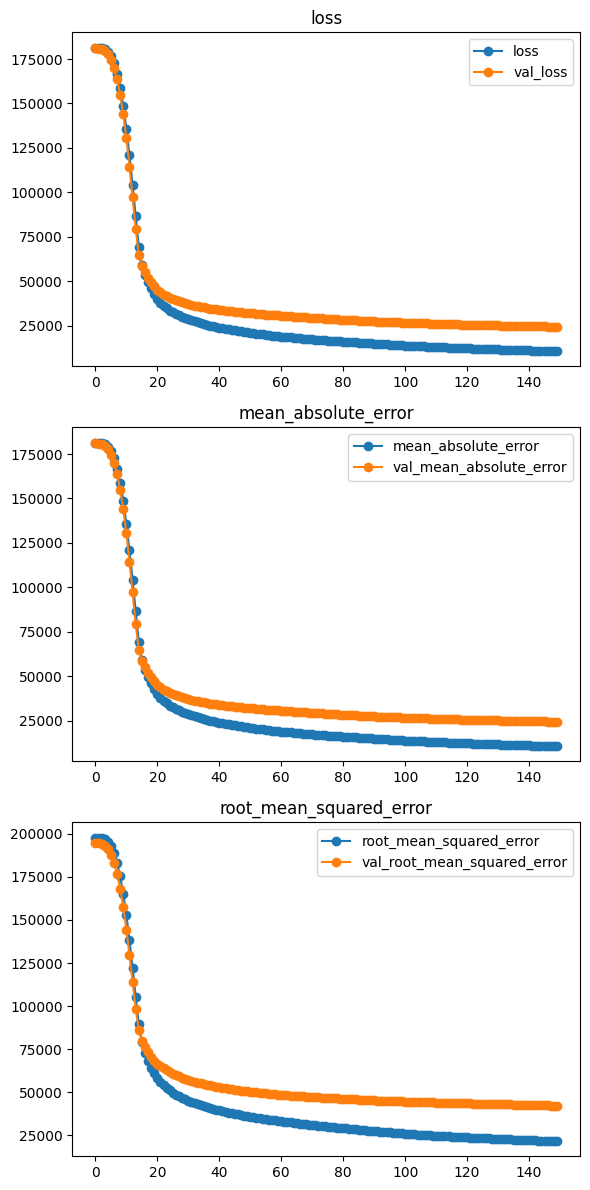

In [25]:
# plot learning
plot_history(history);


In [26]:
print(np.isnan(X_test_scaled).sum())


MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 289, dtype: int64


In [27]:
# evaluate model

y_pred_scaled = reg_model.predict(X_test_scaled)

y_pred_original = price_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_original)):.2f}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred_original):.2f}')
print(f'final R2: {r2_score(y_test, y_pred_original):.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
final RMSE: 14729127867.45
final MAE: 13311624192.00
final R2: -28283961344.0000


In [28]:
# 6. Model 2 - Deeper Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import metrics

def build_model(input_shape):
    model = Sequential()

    model.add(Dense(256, input_dim=input_shape, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.5))

    # model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.5))

    # model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='linear'))

    model.compile(loss='mae', optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model




In [29]:
from tensorflow.keras.callbacks import EarlyStopping

model = build_model(input_shape=289)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = model.fit(X_train_scaled, y_train,
                    validation_split=0.2,
                    epochs=300,
                    batch_size=32,
                    callbacks=[early_stop]
                     )


Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 183205.4062 - mean_absolute_error: 183205.4062 - root_mean_squared_error: 200173.0156 - val_loss: 181048.9219 - val_mean_absolute_error: 181048.9219 - val_root_mean_squared_error: 194480.2031
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 181166.5625 - mean_absolute_error: 181166.5625 - root_mean_squared_error: 198381.5156 - val_loss: 180505.8594 - val_mean_absolute_error: 180505.8594 - val_root_mean_squared_error: 193952.5938
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 181715.7188 - mean_absolute_error: 181715.7188 - root_mean_squared_error: 199416.6406 - val_loss: 177157.2500 - val_mean_absolute_error: 177157.2500 - val_root_mean_squared_error: 190644.2969
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 177728.9844 - mean_absolute_error: 177728.9844 - root_mean_squared_error: 193310.9219 - val_loss: 164186.6094 - val_mean_absolute_error: 164186.6094 - val_root_mean_squared_error: 177848.2812
Epoch 5/

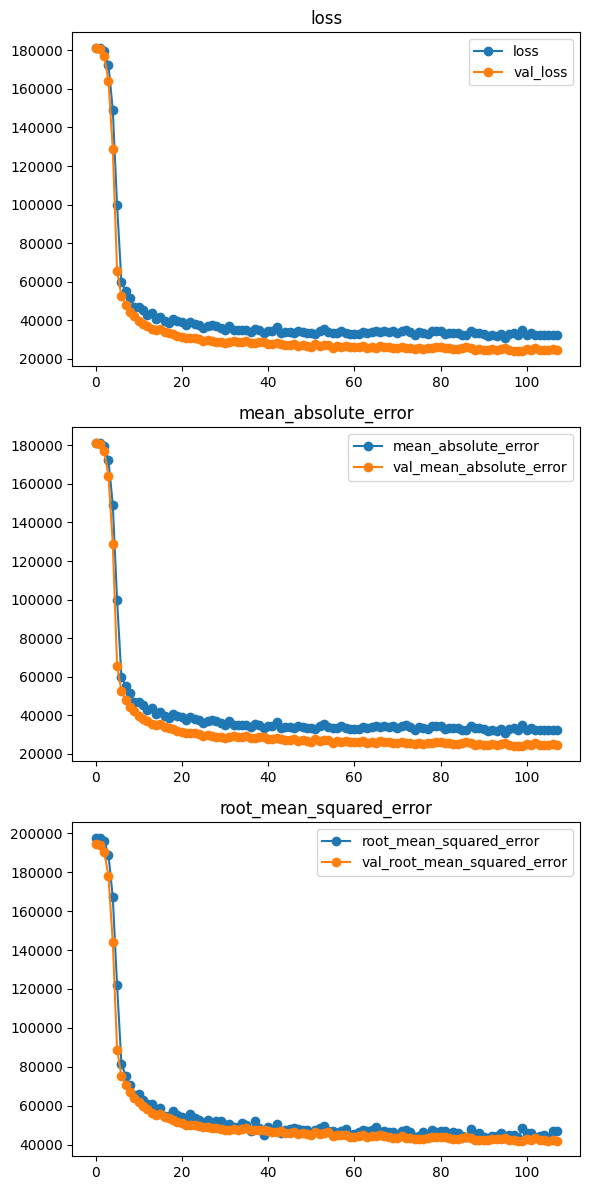

In [30]:
plot_history(history2);
